# **INTRODUCTION**


- **Business Case**

    We will be working with a dataset provided by Geely Auto, a Chinese automotive company aspiring to enter the American market. They have collected a large dataset of different types of cars across the American market to understand the factors affecting car prices.

    We will use this data to train our model, adjusting the coefficients to minimize the error between the model’s predictions and the actual car prices. By doing this, we hope to identify which variables are significant in predicting a car’s price and how well these variables describe a car’s price.

In [169]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error,r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV


Loading Dataset

In [170]:
df = pd.read_csv("data/car_price.csv")

In [171]:
# Defining All Common Functions at the top as part of code organization

# create a function to visualize the numerical columns
def histogram(column_name):
    sns.histplot(data=df[column_name], bins=50, kde=True)
    plt.title(column_name+' distribution')
    plt.xticks(rotation=90)
    plt.show()

# Create a box plot between a categorical column and price
def box_plot(df, column_name):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column_name, y='price', data=df)
    plt.title(f'Box Plot: {column_name} vs. Price')
    plt.xlabel(column_name)
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.show()

# Get Unique Values for Categorical Columns passed as a list
def unique_values(df, categorical_columns):
    for column in categorical_columns:
        print(f"Unique Values for {column} = {df[column].unique()}")
        print(f"Total Unique Values for {column} = {df[column].nunique()}")
        print()

# Clean up the column value by keeping the first word of the column value and converting it to lower case for consistency
def clean_column_value(column_name):
    return column_name.split(" ")[0].lower()

In [172]:
df.head()
print("Total count:",df.shape[0])

Total count: 210


In [173]:
df.describe()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,0.828571,98.947143,174.354286,65.935714,53.768571,2565.909524,127.266667,3.333905,3.258286,10.224381,104.000000,5110.476190,25.180952,30.695238,13289.665081
std,1.244757,6.172319,12.457557,2.141794,2.489242,522.279331,41.297095,0.270150,0.311277,4.068746,39.114725,484.530811,6.487059,6.835908,7918.471818
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,0.000000,94.500000,166.800000,64.125000,52.000000,2174.250000,98.000000,3.150000,3.110000,8.525000,70.000000,4800.000000,19.000000,25.000000,7823.000000
50%,1.000000,97.000000,173.200000,65.500000,54.100000,2422.500000,120.000000,3.320000,3.290000,9.000000,95.000000,5100.000000,24.000000,30.000000,10470.000000
75%,2.000000,102.400000,183.500000,66.900000,55.575000,2953.500000,145.750000,3.587500,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16502.250000
max,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


<font color='navy'>**Findings**</font>: <br/>Based on the above data, we can see the following:
<li><b>count</b>: All columns have 210 records. No null values.</li>
<li><b>mean</b>: Depicts the mean values of all the columns along with the mean value of $13289 for price of the car</li>
<li><b>outliers</b>: Based on evaluation of standard deviation, min max and other values, their seems to be a select few outliers like compression ratio, horsepower and price. Further analysis will be needed on it.</li>

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CarName           210 non-null    object 
 1   carbody           210 non-null    object 
 2   drivewheel        210 non-null    object 
 3   enginelocation    210 non-null    object 
 4   fueltype          210 non-null    object 
 5   aspiration        210 non-null    object 
 6   doornumber        210 non-null    object 
 7   cylindernumber    210 non-null    object 
 8   enginetype        210 non-null    object 
 9   fuelsystem        210 non-null    object 
 10  symboling         210 non-null    int64  
 11  wheelbase         210 non-null    float64
 12  carlength         210 non-null    float64
 13  carwidth          210 non-null    float64
 14  carheight         210 non-null    float64
 15  curbweight        210 non-null    int64  
 16  enginesize        210 non-null    int64  
 1

<font color='navy'>**Findings**</font>: <br/>Based on the above data, we can see the following:
<li><b>Total Count</b>: 210</li>
<li><b>Data Types</b>: We have columns with both numeric and object datatypes</li>

<Axes: >

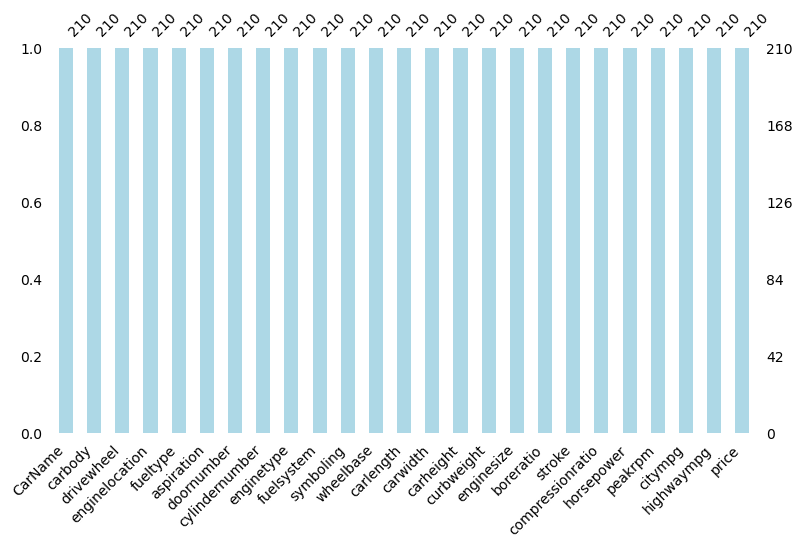

In [175]:
# Using the missingno library to visualize the missing values
fig = plt.figure(figsize=(20, 5))
msno.bar(df, color="#ADD8E6", ax=fig.add_subplot(1,2,1), fontsize=10)

<font color='navy'>**Findings**</font>: <br/>Based on the above data, we can see the following:
<li><b>count</b>: Confirming all columns have 210 records. No null values.</li>

In [176]:
# Creating a list of categorical columns and numerical columns
categorical_columns = df.select_dtypes(include=object).columns.tolist()
numerical_columns = df.select_dtypes(exclude=object).columns.tolist()

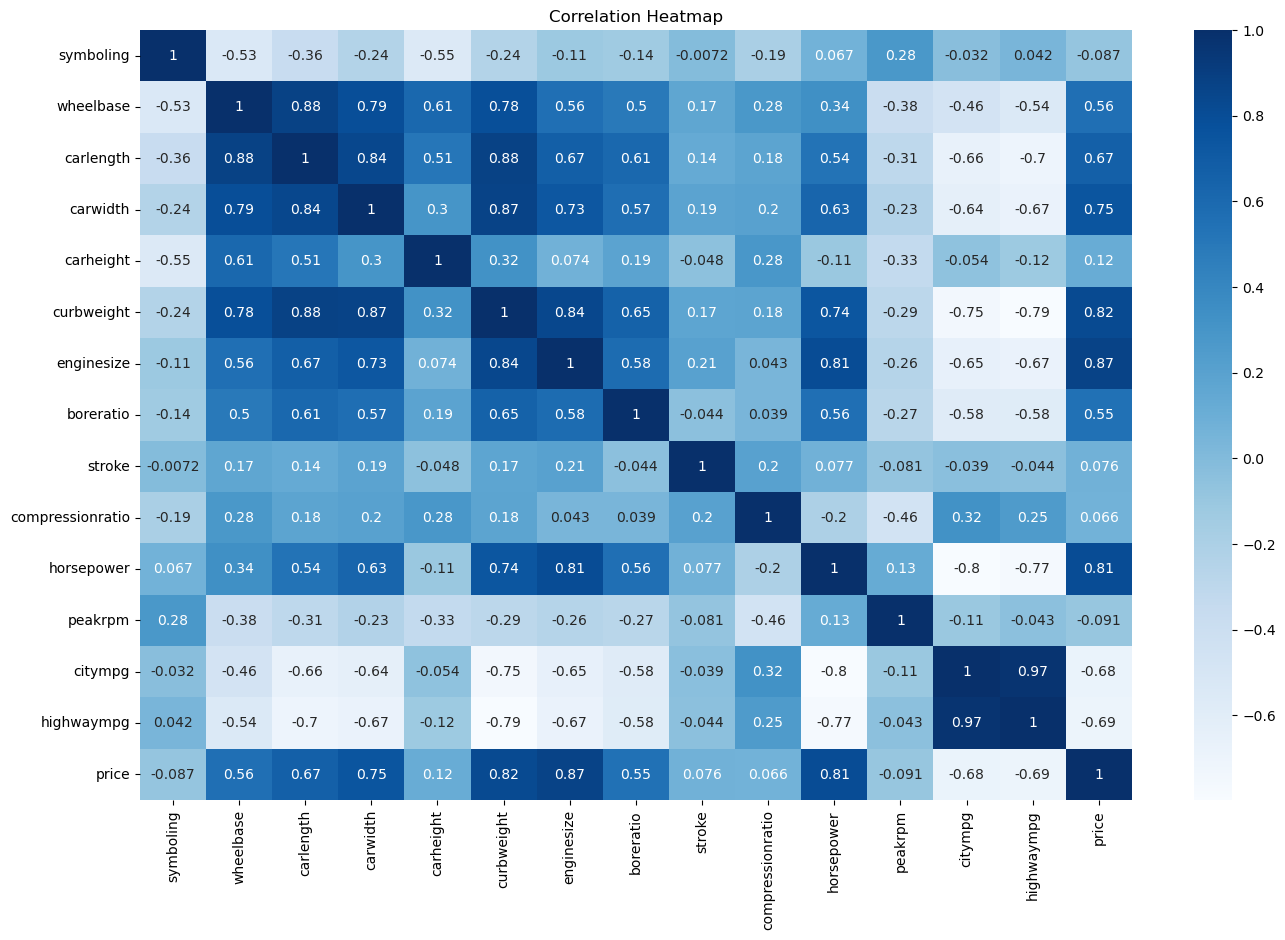

In [177]:
# By inspecting the corelation matrix, we'll be able to see which numerical columns
# have co-relation with price which is our target prediction value.
correlation_matrix = df[numerical_columns].corr()
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
plt.title("Correlation Heatmap")
plt.show()

<font color='green'>**Findings**</font>: <br/>Based on the above data, we can see the following:
<li>By setting the <b>Threshold</b> to: 0.60
<li><b>Price</b>: Considering the above threshold of 0.6, Price has high co-relation with <b>enginesize</b>, <b>horsepower</b>, <b>curbweight</b>, <b>carwidth</b> and <b>carlength</b> and less co-relation with the other parameters. It signifies that highly co-related values have a direct impact on the price of the car</li> 

<font color='green'>**Data Cleanup**</font>: <br/> Before we further analyze the data, we'll evaluate and clean up the bad data to make sure it doesn't negatively impact our model for predicting price. The listed steps below will be followed:
<li> Check if we have duplicate or null values in any rows</li>
<li> If duplicate rows found, remove them</li>
<li> If null values found, evaluate the data to see if the null values can be filled with similar values from other rows. If not, remove those rows</li>
<li> Determine the unique values in each object column</li>
<li> Evaluate the data to see if we can clean up the values by either replacing with the values from other columns to standardize it or breakdown/replace the values where it makes sense and keep the newly created values that provides better/correct meaning to the data</li>

In [178]:
print("Duplicate values =",df.duplicated().sum())
print("Null values =", sum(df.isnull().sum()))

Duplicate values = 5
Null values = 0


In [179]:
# Dropping the duplicate values
df.drop_duplicates(inplace=True)
print("Duplicate values =",df.duplicated().sum())
print("Total remaining count:", df.shape[0])

Duplicate values = 0
Total remaining count: 205


<font color='green'>**Findings**</font>: <br/>Based on the above data, we can see the following:
<li><b>Null values</b>: No Null values found</li> 
<li><b>Duplicate Records</b>: 5 duplicate records found and removed.</li> 

In [180]:
# Evaluate Unique Values for each of the Object columns
unique_values(df, categorical_columns)

Unique Values for CarName = ['alfa-romero giulia' 'alfa-romero stelvio' 'alfa-romero Quadrifoglio'
 'audi 100 ls' 'audi 100ls' 'audi fox' 'audi 5000' 'audi 4000'
 'audi 5000s (diesel)' 'bmw 320i' 'bmw x1' 'bmw x3' 'bmw z4' 'bmw x4'
 'bmw x5' 'chevrolet impala' 'chevrolet monte carlo' 'chevrolet vega 2300'
 'dodge rampage' 'dodge challenger se' 'dodge d200' 'dodge monaco (sw)'
 'dodge colt hardtop' 'dodge colt (sw)' 'dodge coronet custom'
 'dodge dart custom' 'dodge coronet custom (sw)' 'honda civic'
 'honda civic cvcc' 'honda accord cvcc' 'honda accord lx'
 'honda civic 1500 gl' 'honda accord' 'honda civic 1300' 'honda prelude'
 'honda civic (auto)' 'isuzu MU-X' 'isuzu D-Max ' 'isuzu D-Max V-Cross'
 'jaguar xj' 'jaguar xf' 'jaguar xk' 'maxda rx3' 'maxda glc deluxe'
 'mazda rx2 coupe' 'mazda rx-4' 'mazda glc deluxe' 'mazda 626' 'mazda glc'
 'mazda rx-7 gs' 'mazda glc 4' 'mazda glc custom l' 'mazda glc custom'
 'buick electra 225 custom' 'buick century luxus (sw)' 'buick century'
 'buick

In [181]:
# Search for rows with value of enginetype as 'l'
df[df['enginetype'] == 'l']

,CarName,carbody,drivewheel,enginelocation,fueltype,aspiration,doornumber,cylindernumber,enginetype,fuelsystem,...,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
18,chevrolet impala,hatchback,fwd,front,gas,std,two,three,l,2bbl,...,1488,61,2.91,3.03,9.5,48,5100,47,53,5151.0
107,peugeot 504,sedan,rwd,front,gas,std,four,four,l,mpfi,...,3020,120,3.46,3.19,8.4,97,5000,19,24,11900.0
108,peugeot 304,sedan,rwd,front,diesel,turbo,four,four,l,idi,...,3197,152,3.70,3.52,21.0,95,4150,28,33,13200.0
109,peugeot 504 (sw),wagon,rwd,front,gas,std,four,four,l,mpfi,...,3230,120,3.46,3.19,8.4,97,5000,19,24,12440.0
110,peugeot 504,wagon,rwd,front,diesel,turbo,four,four,l,idi,...,3430,152,3.70,3.52,21.0,95,4150,25,25,13860.0
111,peugeot 504,sedan,rwd,front,gas,std,four,four,l,mpfi,...,3075,120,3.46,2.19,8.4,95,5000,19,24,15580.0
112,peugeot 604sl,sedan,rwd,front,diesel,turbo,four,four,l,idi,...,3252,152,3.70,3.52,21.0,95,4150,28,33,16900.0
113,peugeot 504,wagon,rwd,front,gas,std,four,four,l,mpfi,...,3285,120,3.46,2.19,8.4,95,5000,19,24,16695.0
114,peugeot 505s turbo diesel,wagon,rwd,front,diesel,turbo,four,four,l,idi,...,3485,152,3.70,3.52,21.0,95,4150,25,25,17075.0
115,peugeot 504,sedan,rwd,front,gas,std,four,four,l,mpfi,...,3075,120,3.46,3.19,8.4,97,5000,19,24,16630.0


In [182]:
# Clean up car name
df['CarName'] = df['CarName'].apply(clean_column_value)
df['CarName'].unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

In [183]:
df['CarName'] = df['CarName'].replace('toyouta', 'toyota')
df['CarName'] = df['CarName'].replace('porcshce', 'porsche')
df['CarName'] = df['CarName'].replace('vw', 'volkswagen')
df['CarName'] = df['CarName'].replace('vokswagen', 'volkswagen')
df['CarName'] = df['CarName'].replace('maxda', 'mazda')
df['CarName'] = df['CarName'].replace('alfa-romero', 'alfa-romeo')


In [184]:
df.head(10)

,CarName,carbody,drivewheel,enginelocation,fueltype,aspiration,doornumber,cylindernumber,enginetype,fuelsystem,...,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,alfa-romeo,convertible,rwd,front,gas,std,two,four,dohc,mpfi,...,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.000
1,alfa-romeo,convertible,rwd,front,gas,std,two,four,dohc,mpfi,...,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.000
2,alfa-romeo,hatchback,rwd,front,gas,std,two,six,ohcv,mpfi,...,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.000
3,audi,sedan,fwd,front,gas,std,four,four,ohc,mpfi,...,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.000
4,audi,sedan,4wd,front,gas,std,four,five,ohc,mpfi,...,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.000
5,audi,sedan,fwd,front,gas,std,two,five,ohc,mpfi,...,2507,136,3.19,3.40,8.5,110,5500,19,25,15250.000
6,audi,sedan,fwd,front,gas,std,four,five,ohc,mpfi,...,2844,136,3.19,3.40,8.5,110,5500,19,25,17710.000
7,audi,wagon,fwd,front,gas,std,four,five,ohc,mpfi,...,2954,136,3.19,3.40,8.5,110,5500,19,25,18920.000
8,audi,sedan,fwd,front,gas,turbo,four,five,ohc,mpfi,...,3086,131,3.13,3.40,8.3,140,5500,17,20,23875.000
9,audi,hatchback,4wd,front,gas,turbo,two,five,ohc,mpfi,...,3053,131,3.13,3.40,7.0,160,5500,16,22,17859.167


<font color='green'>**Findings**</font>: <br/>Based on the above data, we can see the following:
<li><b>Engine Type of 'l'</b>: It seemed it had an incorrect value and needs to be replace but an alternate was not found. Same data was kept. </li> 
<li><b>Car Name</b>: Car Name had lot of variations. It would be hard to obtain the uniqueness since lot of records will be treated as individual records. Instead, the brand was split from the car name and was used. Also, some of the brand name values were spelled incorrectly which were replaced with the right values i.e. 'toyouta' to 'toyota'  </li> 

<font color='green'>**Data Evaluation**</font>: <br/>Now we'll look at the details of the data to understand it better. The following steps will be followed
<li><b>Histogram</b>: We'll plot the histogram of all columns to understand how individual column values are spread across all the records.</li> 
<li><b>Box Plot</b>: Once the histogram are evaluated, we'll review the price vs. categorical column values using the box plot. Evaluation of it will help us determine if a specific categorical column has a direct impact on price and if there are any outliers.  </li> 

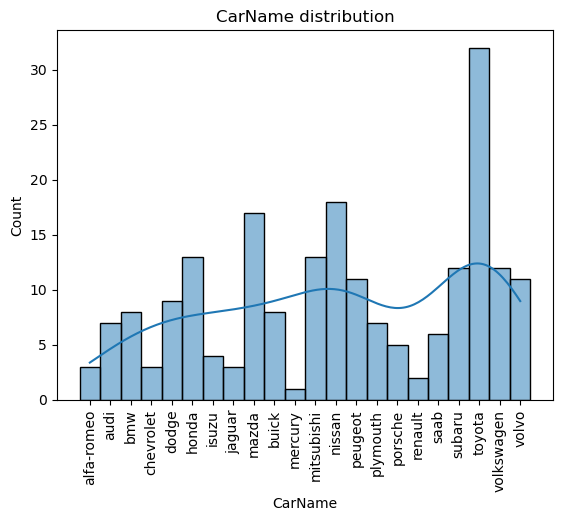

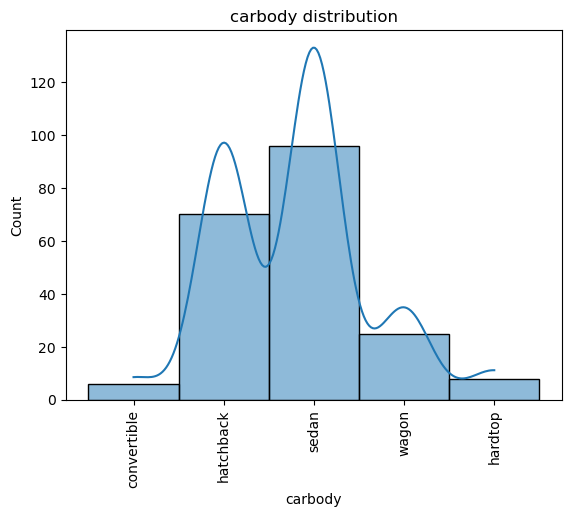

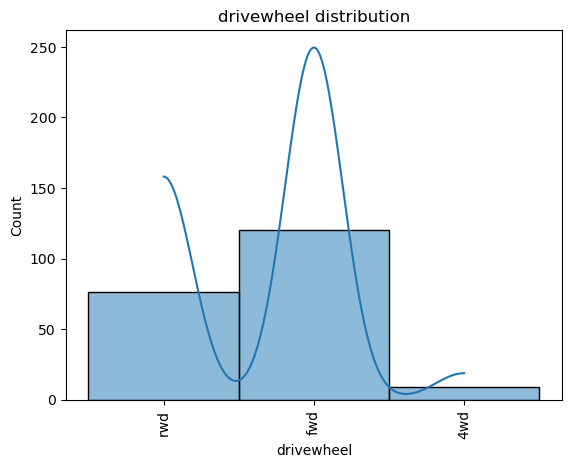

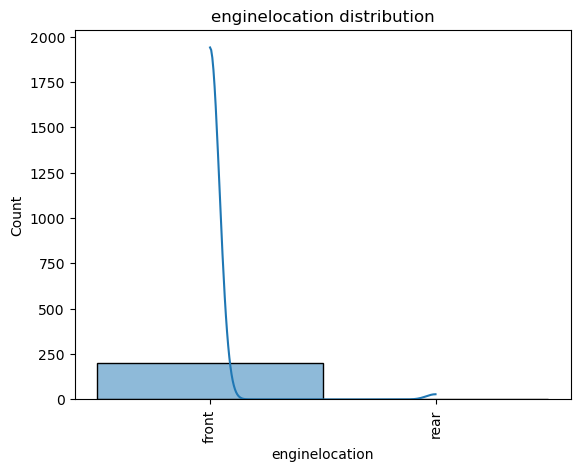

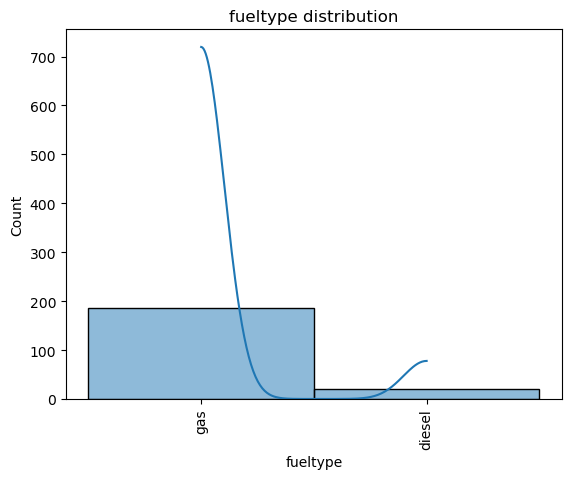

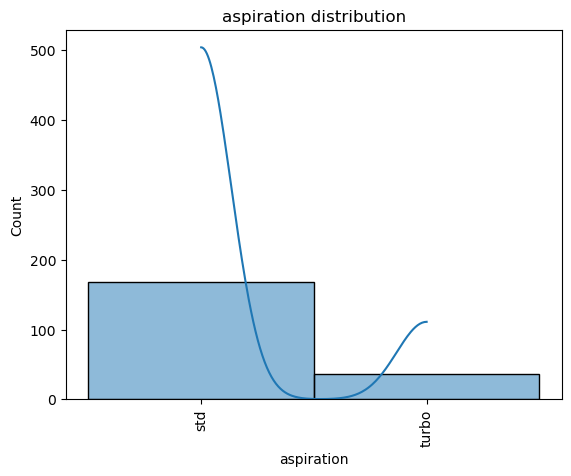

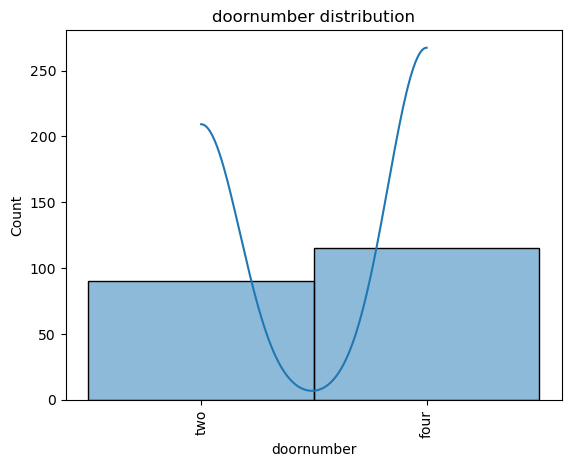

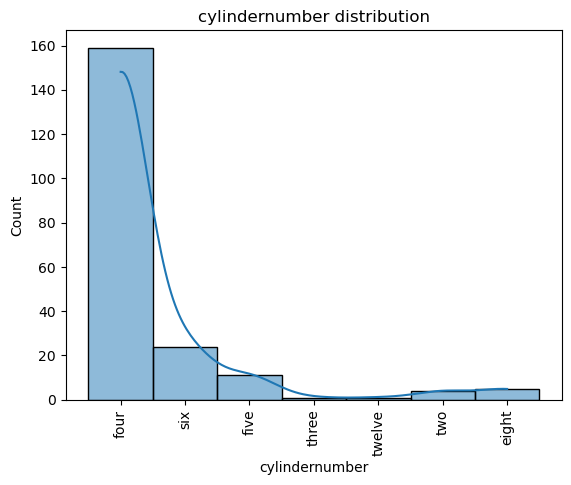

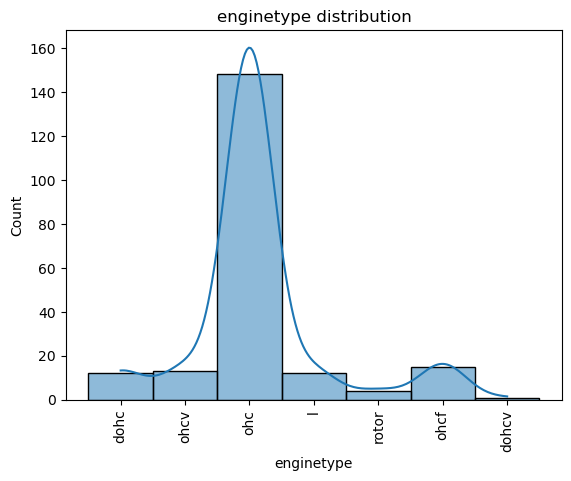

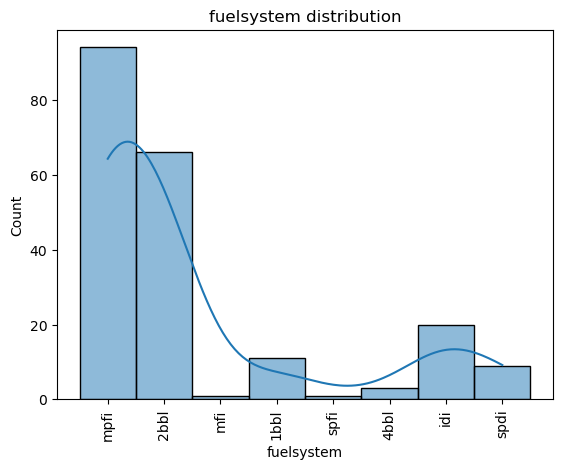

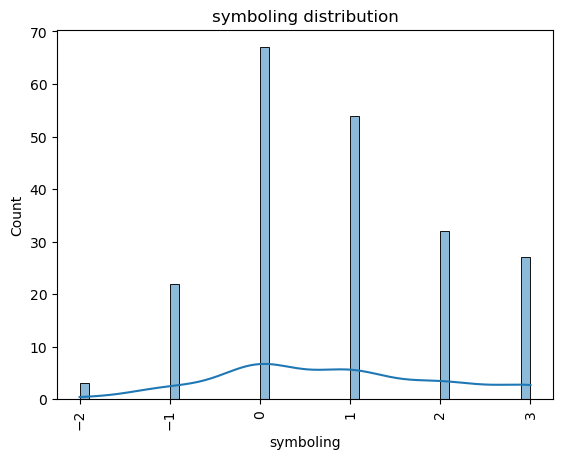

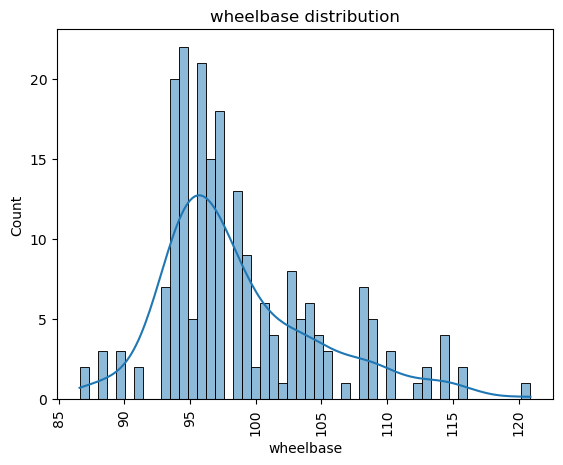

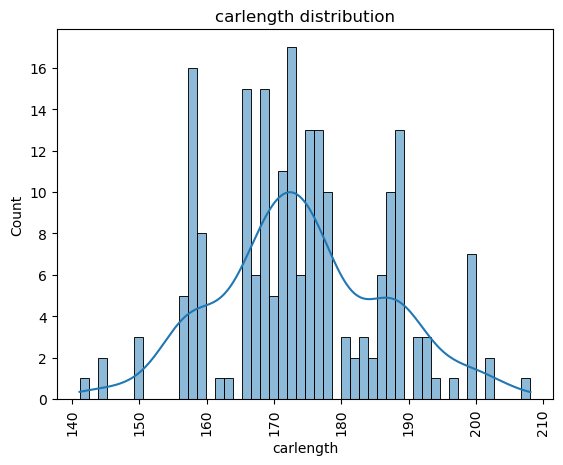

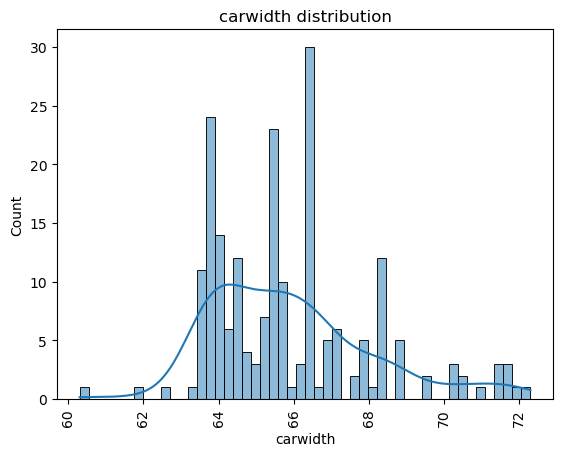

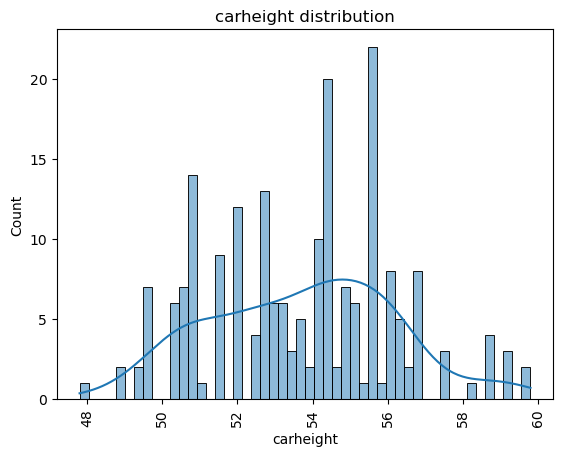

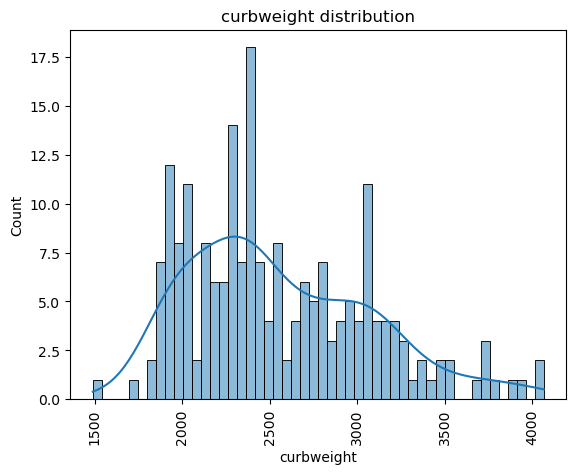

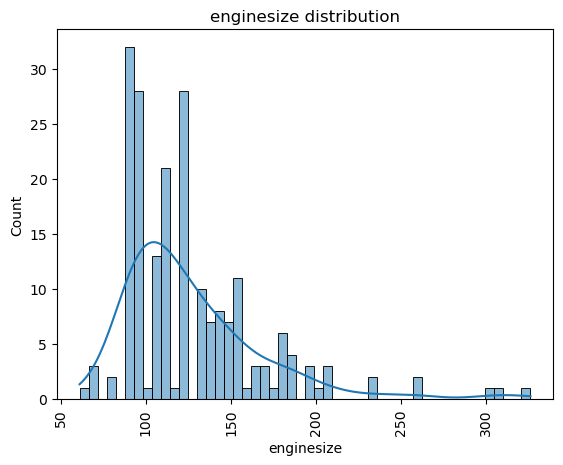

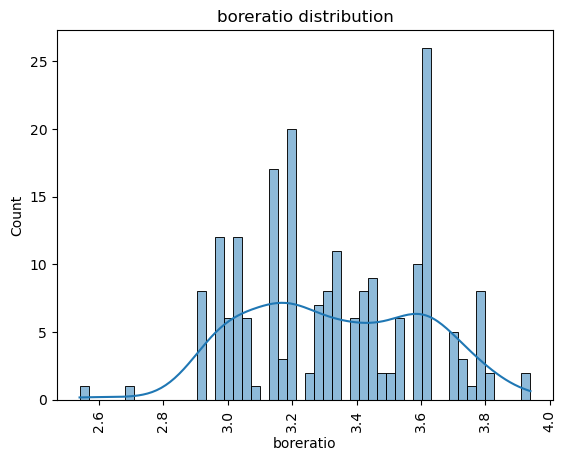

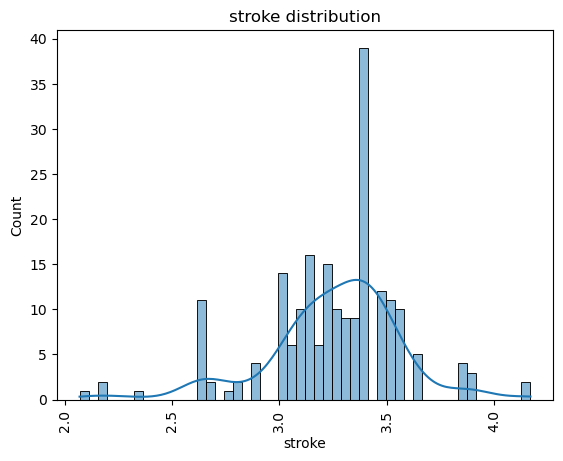

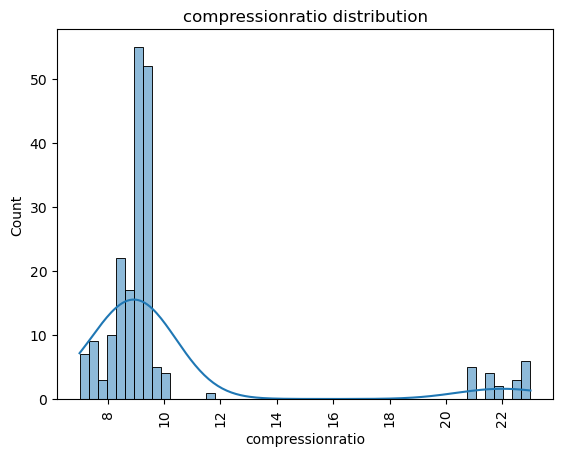

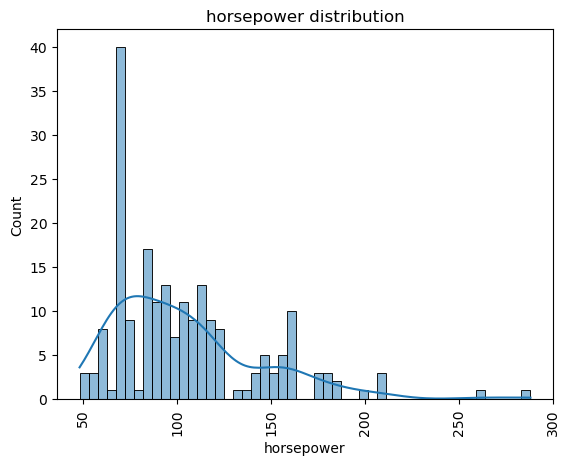

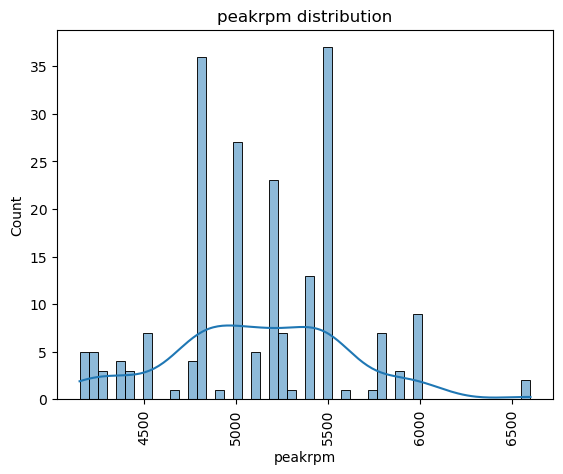

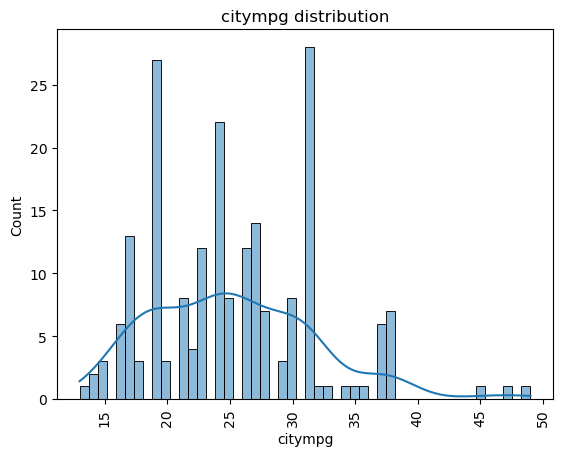

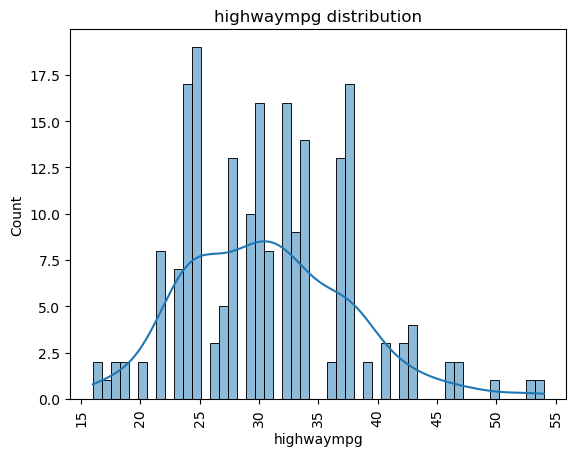

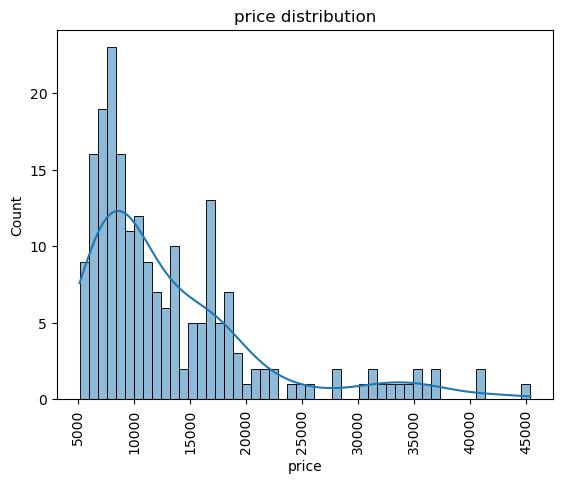

In [185]:
# Plot histograms of all columns to see the distribution of each value  in the column
for column in df.columns:
    histogram(column)  # Calling the histogram function defined above

<font color='green'>**Findings**</font>: <br/>Based on the above data, we can see the following:
<li><b>Data distribution</b>: Data is distributed properly for most columns </li> 
<li><b>Exception columns</b>: Data for stroke, compression ratio and boreratio are not distributed evenly but still need to be kept since the higher values have a direct relationship with the price  </li> 

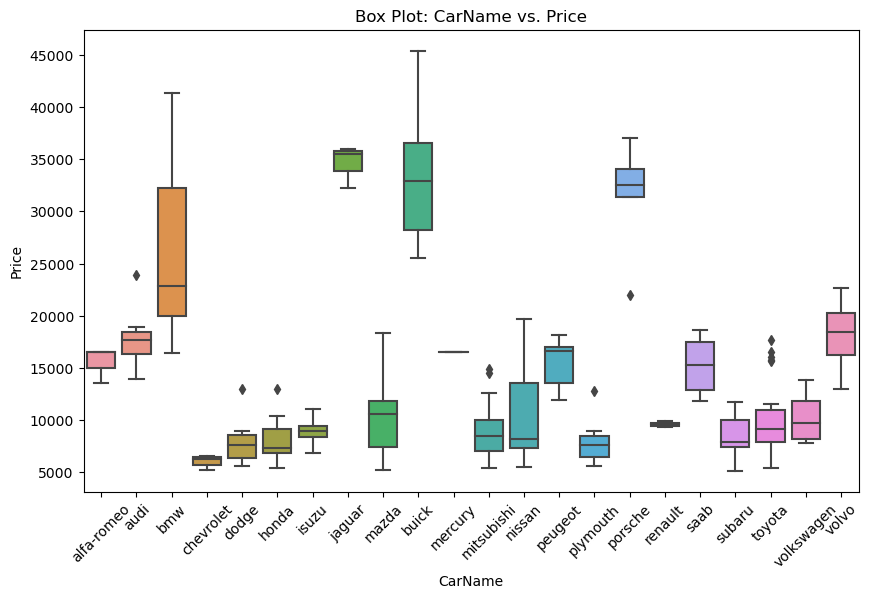

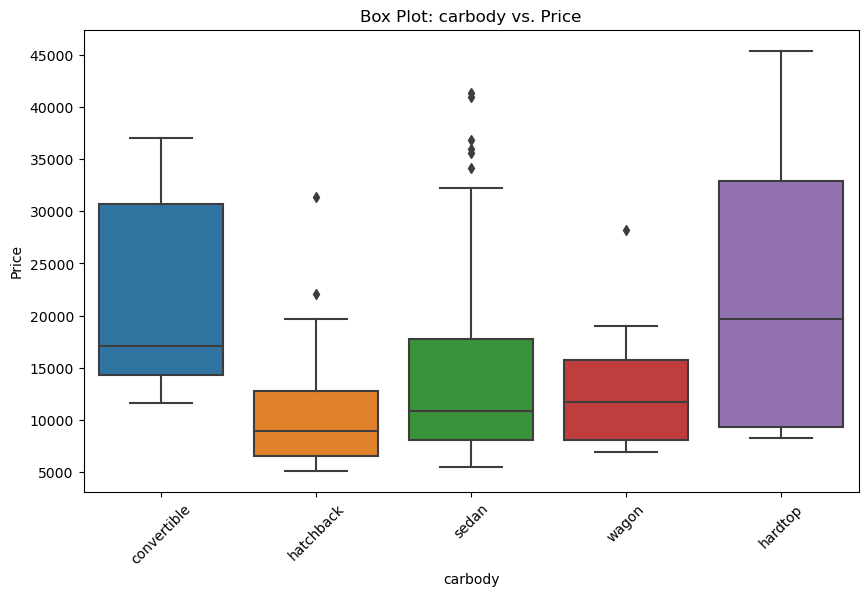

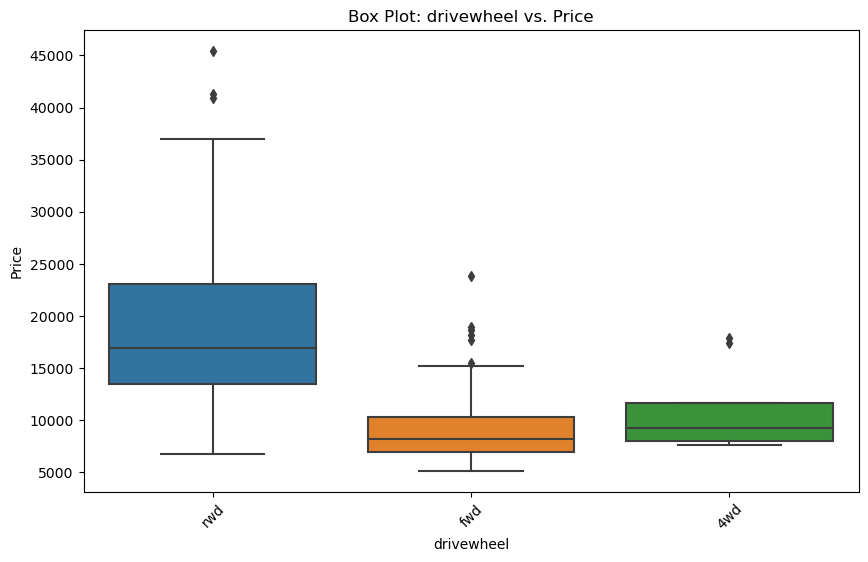

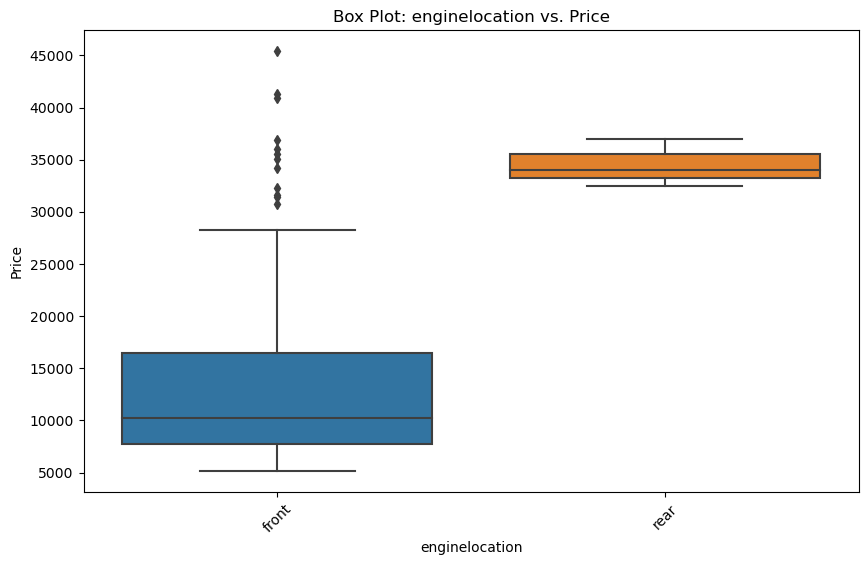

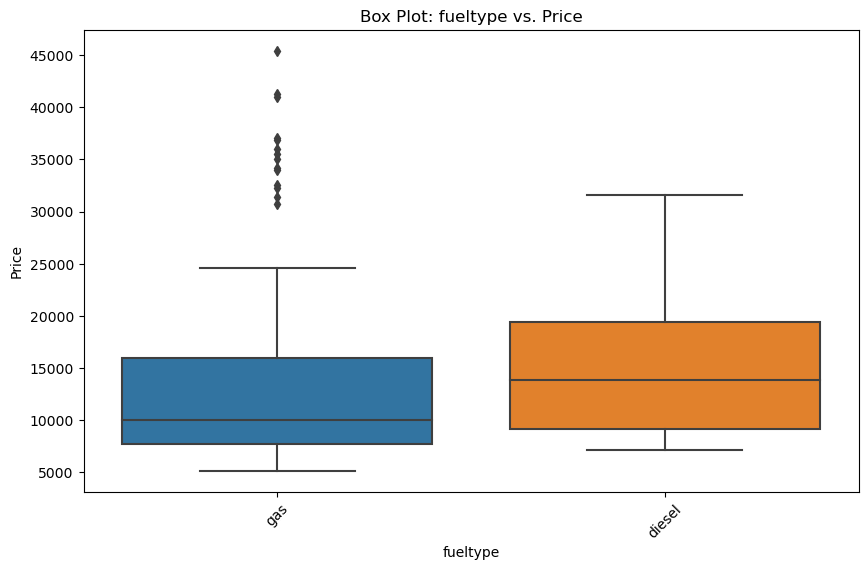

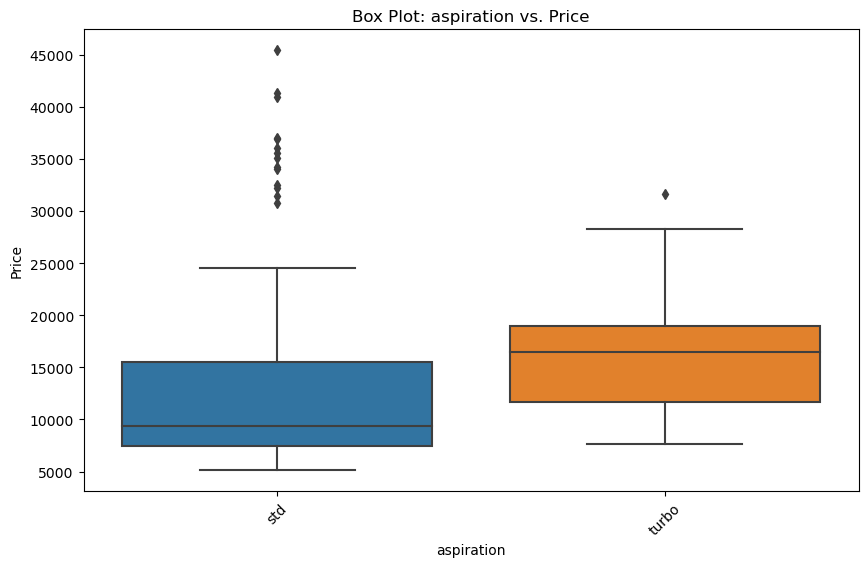

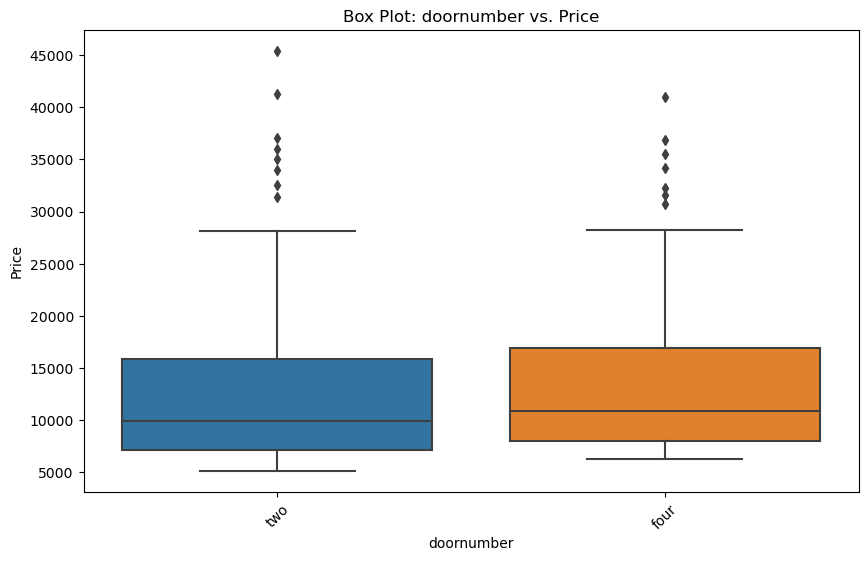

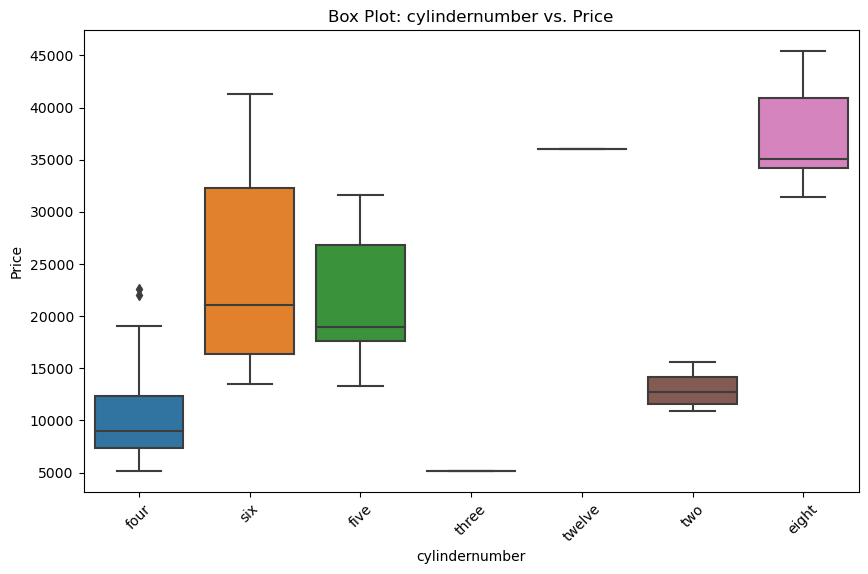

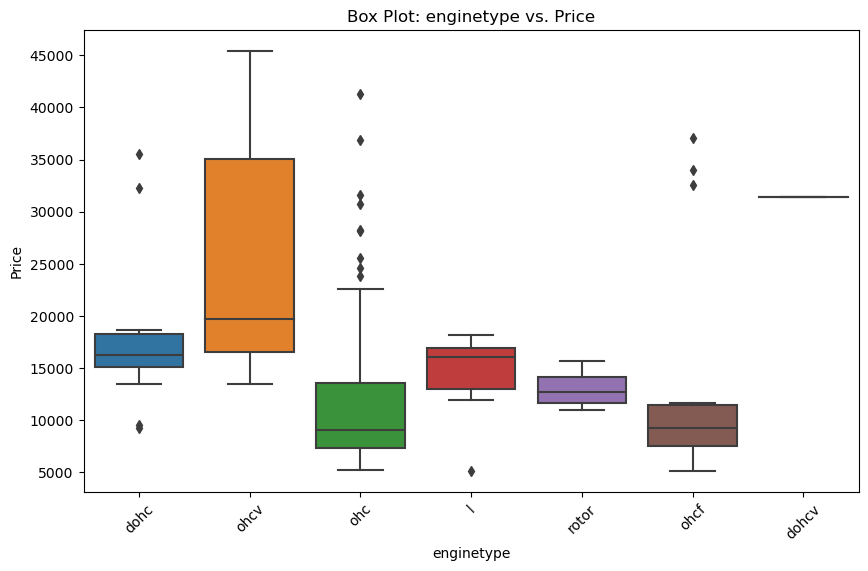

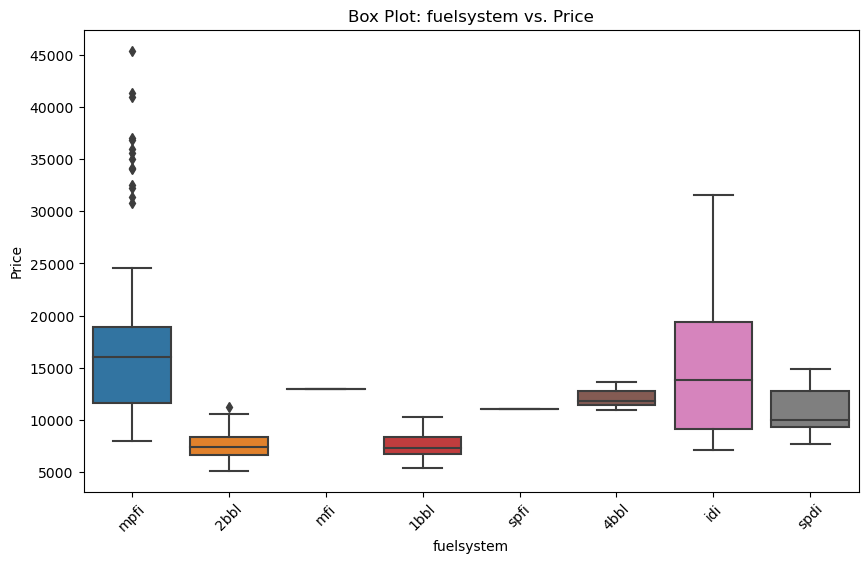

In [186]:
# Now, we need to see if the categorical columns have any impact on the price

# Plot box plots for all categorical columns vs. price
for column in categorical_columns:
    box_plot(df, column)

<font color='green'>**Findings**</font>: <br/>Based on the above data, we can see the following:
<li><b>Categorical Columns</b>: Based on the plots, it seems all categorical columns have some impact on the price. 
<li><b>Data Outliers</b>: No data outliers are seen so we'll keep all the data and not remove any values based on IQR evaluation. We'll also keep all categorical columns for further analysis.  </li> 

<font color='green'>**Data Prepocessing**</font>: <br/>
<li><b>OneHotEncoding</b>: Now we'll use get_dummies method which uses OneHotEncoding to encode the object values in to numeric values. This helps machine learning algorithms to improve predictions by including those columns.</li> 
<li><b>Principal Component Analysis (PCA)</b>: After that, we'll use PCA to extract key features that have direct impact on the price and reduce dimensionality of the dataframe </li> 

In [187]:
# Now using OneHotEncoding for converting categorical columns to numerical columns
df = pd.get_dummies(data=df, columns=categorical_columns, drop_first=True)

In [188]:
df.head(10)

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,...,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
0,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,...,False,False,False,False,False,False,False,True,False,False
1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,...,False,False,False,False,False,False,False,True,False,False
2,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,...,False,True,False,False,False,False,False,True,False,False
3,2,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,...,False,False,False,False,False,False,False,True,False,False
4,2,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,...,False,False,False,False,False,False,False,True,False,False
5,2,99.8,177.3,66.3,53.1,2507,136,3.19,3.40,8.5,...,False,False,False,False,False,False,False,True,False,False
6,1,105.8,192.7,71.4,55.7,2844,136,3.19,3.40,8.5,...,False,False,False,False,False,False,False,True,False,False
7,1,105.8,192.7,71.4,55.7,2954,136,3.19,3.40,8.5,...,False,False,False,False,False,False,False,True,False,False
8,1,105.8,192.7,71.4,55.9,3086,131,3.13,3.40,8.3,...,False,False,False,False,False,False,False,True,False,False
9,0,99.5,178.2,67.9,52.0,3053,131,3.13,3.40,7.0,...,False,False,False,False,False,False,False,True,False,False


In [189]:
from sklearn.decomposition import PCA

# Splitting the data into X and y
X = df.drop('price', axis=1)
y = df['price']

# Instantiating PCA object
pca = PCA()

# Fit and transform the data
df_pca = pca.fit_transform(X)

# Convert to DataFrame
df_pca = pd.DataFrame(df_pca)

# Get the feature weights for the first principal component
pc1_weights = pca.components_[0]
#print(pc1_weights)
# Get the indices of the features sorted by weight
sorted_indices = np.argsort(np.abs(pc1_weights)) #[::-1] - Testing descending order
print(sorted_indices)
# Get the names of the features
feature_names = X.columns

# Print the top features for the first principal component
print("Top features for first principal component:")
for i in sorted_indices[-5:]:  # top 5 features you want
    print(f"{feature_names[i]}: {pc1_weights[i]}")

#df_pca.head(10)


[-6.69010337e-04  8.07903925e-03  1.74437629e-02  2.87975233e-03
  1.62940719e-03  8.11764720e-01  5.59890404e-02  2.93244249e-04
  8.88195085e-05  2.28432324e-03  3.51111126e-02 -5.79826498e-01
 -5.95321848e-03 -6.98305999e-03 -1.84883817e-06  4.15904818e-05
  1.59486972e-04 -3.46161908e-05 -6.65430486e-05 -1.47089511e-04
 -1.80317868e-05  6.31739094e-05 -5.24874789e-05  5.56289363e-06
 -4.47695479e-05 -4.31179327e-05  1.35602319e-04 -4.37112467e-05
 -8.10621229e-06 -4.54152686e-07  3.13809745e-06  1.26298900e-06
  2.94852205e-05 -3.51032802e-05  5.00580129e-05  3.25101105e-05
 -2.46858043e-04  1.02891019e-04  9.46508238e-05 -4.90228106e-04
  4.67337484e-04 -1.22703477e-05 -2.07640132e-04  2.27033546e-04
 -2.35817573e-04  8.34553601e-05 -3.03988868e-04  1.70439805e-04
 -1.31342018e-05  1.86871613e-05 -3.83810955e-05  4.68646670e-06
  1.22468117e-04 -2.57912548e-04 -1.10073587e-05  1.43346231e-04
 -3.83810955e-05 -3.20739082e-04 -2.99079973e-05  2.07640132e-04
  4.32873457e-06  2.81471

<font color='green'>**Findings**</font>: <br/>Based on the above data, we can see the following:
<li><b>Top 5 features</b>: The features which seems to have the most price impact are <b>carlength</b>, <b>horsepower</b>, <b>enginesize</b>, <b>peakrpm</b> and <b>curbweight</b>.
<li><b>Anomaly</b>: Eventhough peakrpm is shown as one of the selected features, this contradicts with the corelation matrix analysis we had prior where peakrpm had a low corelation with price </li> 

<font color='green'>**Data Modeling**</font><br/>Now, the following steps will be followed:
<li><b>Training & Test Datasets</b>: We'll break down the data in training and test sets</li> 
<li><b>Create Pipelines</b>: To train the models, we'll do the following: <br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1. Create Pipeline with <b>StandardScaler</b> (to normalize the data) <br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2. <b>PolynomialFeatures</b> (model the relationship between features and target variable) <br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3. Regression models we want the data to be trained for. i.e <b>LinearRegression</b> ,<b>RidgeRegression</b> ,<b>Random Forest Regressor</b> ,<b>Stochaistic Gradient Descent Regressor</b> ,<b>Extreme Gradient Boost Regressor</b>.<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4. Use <b>GridSearchCV</b> to train the models using multiple range of hyperparameters to find the best model.</li>
<li><b>Predict Target Variable</b>: Using the trained model, we'll predict the target variable</li>
<li><b>Evaluate Model Performance</b>: Using the predicted value, we'll check how the model performed by calculating Mean Square Error (MSE), Mean Absolute Error (MAE) & R-squared (R2) score. We'll also plot the actual versus. predicted plots to see the data for each of the different models. </li>

Training set count: 164
Training target value count: (164,)
Test set count: (41, 64)
Test target value count: (41,)
Best parameters for lr: {'poly__degree': 1}
Best MSE for lr: 127800062.85194127
Best MAE for lr: 7793.738920454545
Best R2 for lr: -1.5281977847253372


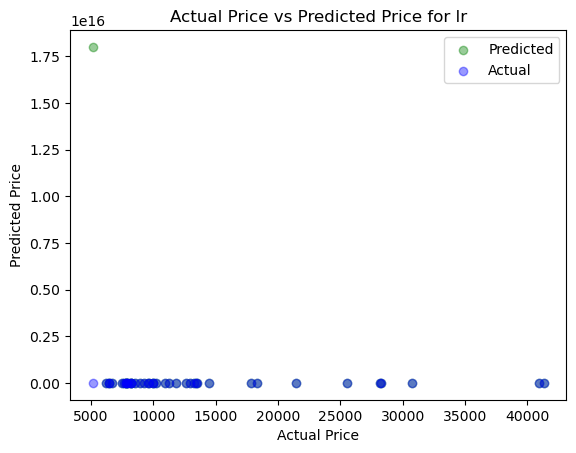

Best parameters for ridge: {'model__alpha': 100.0, 'poly__degree': 3}
Best MSE for ridge: 4819752.600202004
Best MAE for ridge: 1581.0277072921965
Best R2 for ridge: 0.9042880855635183


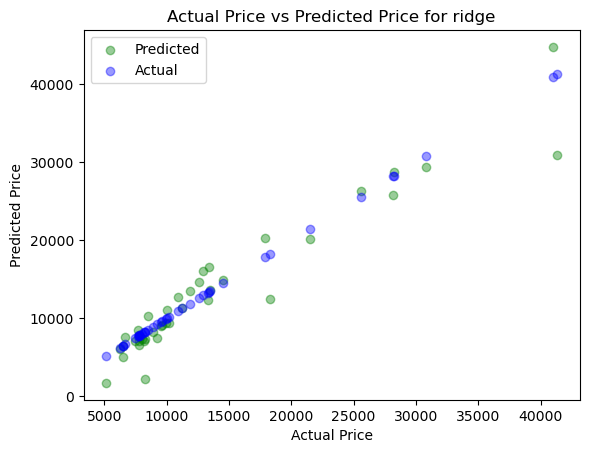

Best parameters for rf: {'model__n_estimators': 150, 'poly__degree': 1}
Best MSE for rf: 5778855.85704503
Best MAE for rf: 1536.414999158249
Best R2 for rf: 0.8918517542373416


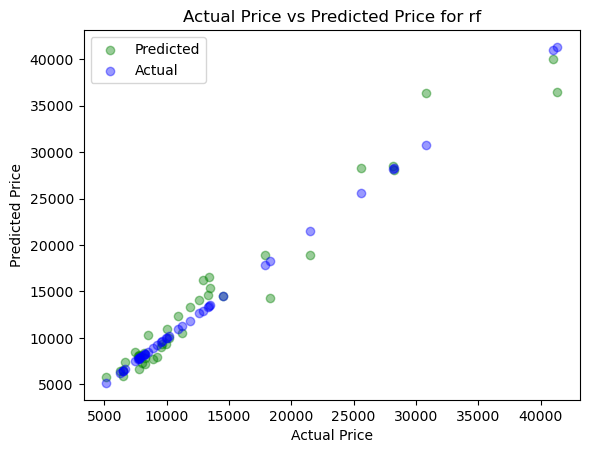

Best parameters for sgd: {'model__alpha': 0.01, 'poly__degree': 1}
Best MSE for sgd: 5056586.333578149
Best MAE for sgd: 1567.4599418530065
Best R2 for sgd: 0.9093021437335187


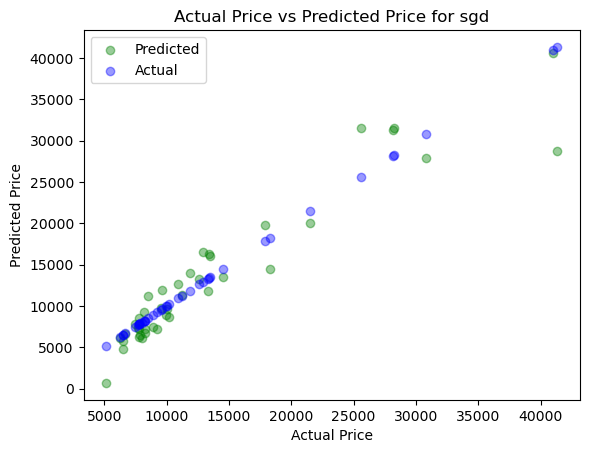

Best parameters for xgb: {'model__learning_rate': 0.1, 'model__n_estimators': 200, 'poly__degree': 1}
Best MSE for xgb: 6489479.252824315
Best MAE for xgb: 1654.8150350859673
Best R2 for xgb: 0.8783598341806306


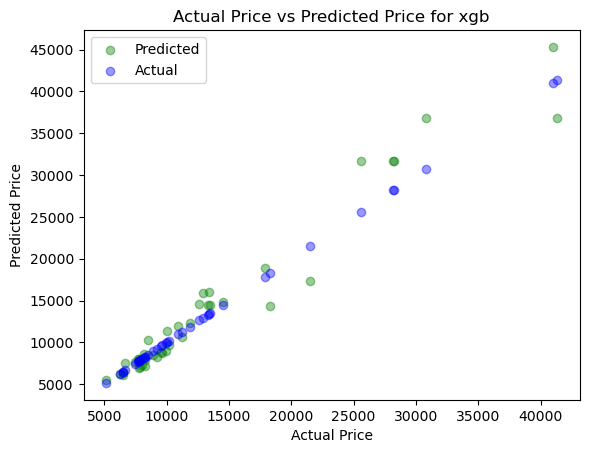

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set count:", X_train.shape[0])
print("Training target value count:", y_train.shape)
print("Test set count:", X_test.shape)
print("Test target value count:", y_test.shape)

# Define the pipelines for each model
pipelines = {
    "lr": Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures()),
        ('model', LinearRegression())
    ]),
    "ridge": Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures()),
        ('model', Ridge())
    ]),
    "rf": Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures()),
        ('model', RandomForestRegressor())
    ]),
    "sgd": Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures()),
        ('model', SGDRegressor())
    ]),
    "xgb": Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures()),
        ('model', XGBRegressor())
    ]),
}

# Define the parameter grids
param_grids = {
    "lr": {
        'poly__degree': [1, 2, 3],
    },
    "ridge": {
        'poly__degree': [1, 2, 3],
        'model__alpha': [0.1, 1.0, 10.0, 100.0],
    },
    "rf": {
        'poly__degree': [1, 2],
        'model__n_estimators': [10, 50, 100, 150],
    },
    "sgd": {
        'poly__degree': [1, 2, 3],
        'model__alpha': [0.0001, 0.001, 0.01],
    },
    "xgb": {
        'poly__degree': [1, 2],
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
    }
}

# Define the scoring metrics
scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R2': make_scorer(r2_score)
}

# Create a GridSearchCV object for each model and fit it to the data
for name in pipelines.keys():
    grid_search = GridSearchCV(pipelines[name], param_grids[name], cv=5, scoring=scoring, refit='MSE')
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best MSE for {name}: {-grid_search.best_score_}")
    print(f"Best MAE for {name}: {-grid_search.cv_results_['mean_test_MAE'][grid_search.best_index_]}")
    print(f"Best R2 for {name}: {grid_search.cv_results_['mean_test_R2'][grid_search.best_index_]}")

#     # Plot the predictions
    plt.figure()
    plt.scatter(y_test, grid_search.predict(X_test), color='green', alpha=0.4, label='Predicted')
    plt.scatter(y_test, y_test, color='blue', alpha=0.4, label='Actual')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f"Actual Price vs Predicted Price for {name}")
    plt.legend()
    plt.show()

<font color='green'>**Findings**</font>: <br/>Based on the above data, we can see the following:
<li><b>Best Model</b>: Based on the criteria that the model that has the smallest MAE and MSE and the highest R2, is considered the best model, <b><font color='darkgreen'>Ridge Regression model is the best one followed by SGBRegressor.</font> </b></li> 
<li><b>Worst Model</b>: LinearRegression performed the worst.</li>
<li>Additional model alpha parameters and n_estimator values were added to see if the performance of the model improved or not. The model performance remained the same even after adding those values. </li>